In [61]:
# Libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial

import json
from shapely.geometry import Point, mapping
from shapely.ops import transform

import operator

import random

# Paths and names

In [2]:
# Define path of municipalities shape file

# this is allison's path
# entities_path = 'marco_geoestadistico_2018/'

# this is jerry's path
entities_path = '../marco_geoestadistico_2018/'


In [3]:
# Define a dictionary to read the shape files

entities= {
    '01' :['01Ags','01_aguascalientes'],
    '02' :['02BC','02_bajacalifornia'],
    '03' :['03BCS','03_bajacaliforniasur'],
    '04' :['04Camp', '04_campeche'],
    '05' :['05Coah','05_coahuiladezaragoza'],
    '06' :['06Col','06_colima'],
    '07' :[ '07Chs','07_chiapas'],
    '08' :['08Chih','08_chihuahua'],
    '09' :['09CdMx','09_ciudaddemexico'],
    '10' :['10Dur','10_durango'],
    '11' :['11Gto', '11_guanajuato'],
    '12' :['12Gro','12_guerrero'],
    '13' :['13Hgo','13_hidalgo'],
    '14' :['14Jal','14_jalisco'],
    '15' :['15EdoMex','15_mexico'],
    '16' :['16Mich','16_michoacandeocampo'],
    '17' :['17Mor','17_morelos'],
    '18' :['18Nay','18_nayarit'],
    '19' :['19NL', '19_nuevoleon'],
    '20' :['20Oax', '20_oaxaca'],
    '21' :['21Pue', '21_puebla'],
    '22' :['22Qro','22_queretaro'],
    '23' :['23QRoo','23_quintanaroo'], 
    '24' :['24SLP','24_sanluispotosi'],
    '25' :['25Sin','25_sinaloa'],
    '26' :['26Son','26_sonora'],
    '27' :['27Tab','27_tabasco'],
    '28' :['28Tamps','28_tamaulipas'],
    '29' :['29Tlax','29_tlaxcala'],
    '30' :['30Ver','30_veracruzignaciodelallave'],
    '31' :[ '31Yuc','31_yucatan'],
    '32' :[ '32Zac','32_zacatecas']   
}

# Municipality shapefiles

In [12]:
# Read in municipality shapefiles 

urban_shapes = []

for i in range(1,33):
    a = str(i).zfill(2)
    
    urban_agebs = gpd.read_file(entities_path + entities[a][1]+'/conjunto de datos/'+entities[a][1][0:2]+'mun'+'.shp')
    
    urban_shapes.append(urban_agebs)
    
urban_shapes = pd.concat(urban_shapes)

# Area and centroid calculations

In [13]:
# Find area of all municipalities

# Ensure projection consistency
urban_shapes = urban_shapes.to_crs({'init' :'epsg:4326'})

gs = gpd.GeoSeries(urban_shapes['geometry'])

areas = []
for i in gs:  
    area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=i.bounds[1],
                lat_2=i.bounds[3])),
        i)
    areas.append(area.area/1000000)
    
urban_shapes['area'] = areas

In [14]:
# Find centroid of all municipalities

centroid = gs.centroid
urban_shapes['centroid'] = centroid

# Radius calculations for attractor municipalities

In [15]:
# Read in attractor municipalities

attractors = pd.read_csv('complejidad_alta.csv')

# Standardize ID number
for i in range(0,137):
    attractors['cve_mun'].iloc[i] = str(attractors['cve_mun'].iloc[i]).zfill(5)

/Users/huangruijie/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
# Find radius for each municipality

att_shapes = urban_shapes.loc[urban_shapes['CVEGEO'].isin(attractors['cve_mun'])]

min_area = att_shapes['area'].min()

radius = []
for i in range(0,137):
    area = att_shapes['area'].iloc[i]
    radius.append(50*(math.log(area/min_area,10) + 1))
    
att_shapes['radius'] = radius

/Users/huangruijie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


# Regionalization using radius

In [17]:
# Create a circle with center at the centroid of each attractor municipality and corresponding radius

import math

polygon_list = []
    
def find_circle(point, radius_individual):

    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )
    
    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(radius_individual*1000)

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)

    return (Polygon(buffer_wgs84))

for i in range(att_shapes.shape[0]):
    
    polygon_list.append(find_circle(att_shapes['centroid'].iloc[i],att_shapes['radius'].iloc[i]))

att_shapes['circlerange'] = polygon_list

/Users/huangruijie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# Output csv

phase_1 = urban_shapes

for t in range(att_shapes.shape[0]):
    one_column = []
    
    check_polygon = att_shapes['circlerange'].iloc[t]
    
    for i in range(urban_shapes.shape[0]):
        
        check_point = (urban_shapes['centroid'].iloc[i])
        
        if urban_shapes['CVEGEO'].iloc[i] in attractors['cve_mun'].unique():
            dummy_value = 2 * (check_polygon.contains(check_point))
        else:
            dummy_value = 1 * (check_polygon.contains(check_point))
        
        one_column.append(dummy_value)
    
    temp_str = att_shapes['CVEGEO'].iloc[t]
    
    phase_1[temp_str] = one_column
    
phase_1 = phase_1.drop(['geometry', 'centroid'], axis=1)

export_csv = phase_1.to_csv('phase_1.csv')

In [19]:
# Plot number overlaps for all municipalities

overlap = phase_1.drop(['CVE_ENT', 'CVE_MUN', 'NOMGEO', 'area'], axis=1)

overlap.set_index('CVEGEO', inplace=True)

overlap_t = overlap.T

overlap_count = overlap_t.astype(bool).sum()

for i in attractors['cve_mun']:
    overlap_count[i] = overlap_count[i] - 1

# Merging regions

In [20]:
# Merge attractor regions that overlap with other attractors by complexity, 1 merge per attractor

Merge_dict = {}

for att in overlap.columns:
    Merge_dict[att] = 0
    
merged = pd.DataFrame(index = overlap.index)

for col in attractors['cve_mun']:
    if Merge_dict[col] == 0:
        l = overlap.index[overlap[col] == 2].tolist()
        merged[col] = overlap[col]
        for att in l:
            Merge_dict[att] = 1
            merged[col] = merged[col] + overlap[att]
            

In [21]:
export_csv = merged.to_csv('merged.csv')

In [22]:
# Create dictionary documenting 1-pass regionalization

Reg_dict1 = {}

for col in merged.columns:
    Reg_dict1[col] = merged.index[merged[col] > 0].tolist()

In [23]:
key_list = list(Reg_dict1.keys()) 
val_list = list(Reg_dict1.values()) 

In [24]:
Mun_dict = {}
Mun_count = {}
for mun in overlap.index:
    Mun_dict[mun] = []
    Mun_count[mun] = 0

for mun in overlap.index:
    for key in key_list:
        for i in Reg_dict1[key]:
            if mun == i:
                Mun_dict[mun].append(key)
                Mun_count[mun] += 1

In [25]:
proximity = pd.read_csv('municipality_proximity_matrix_clave_actividad_economica_and_cve_mun_2014_A111A_H001A_6.csv', index_col = 'clave_entidad')

col_head = list(proximity.columns)
col_head_new = []

for n in col_head:
    col_head_new.append(n.zfill(5))
    
proximity.columns = col_head_new

In [26]:
Mun_dict_cut = Mun_dict.copy()

l = ['07058', '07120', '07121', '07122', '07123', '07124', '23011']

for i in l:
    del Mun_dict_cut[i]

In [27]:
Reg_dict2 = {}
no_region = []

for att in key_list:
    Reg_dict2[att] = []
    
Reg_dict2['07089'] = ['07120']
Reg_dict2['07101'] = ['07058', '07121', '07122', '07123', '07124']
Reg_dict2['23005'] = ['23011']
    
for key in Mun_dict_cut:
    Prox_dict = {}
    for item in Mun_dict_cut[key]:
        index = int(key)
        Prox_dict[item] = proximity.at[index,item]
    if Prox_dict:   
        reg = max(Prox_dict.items(), key=operator.itemgetter(1))[0]
        Reg_dict2[reg].append(key)
    else:
        no_region.append(key)

# Phase 2

In [28]:
# Naively merge attractor regions that have higher than .5 proximity measurement and are within the radius range

Reg_dict = {}

for att in overlap.columns:
    Reg_dict[att] = 0

merged = pd.DataFrame(index = overlap.index)

for col in attractors['cve_mun']:
    l = overlap.index[overlap[col] == 2].tolist()
    for att in l:
        index = int(col)
        if proximity.at[index,att] > 0.25:
            main_att = Reg_dict[col]
            if main_att == 0:
                Reg_dict[att] = col
                merged[col] = overlap[att]
            else:
                Reg_dict[att] = main_att
                merged[main_att] = merged[main_att] + overlap[att]

In [29]:
# Create dictionary documenting attractor proximity regionalization

Reg_dict3 = {}

for col in merged.columns:
    Reg_dict3[col] = merged.index[merged[col] > 0].tolist()

In [30]:
key_list = list(Reg_dict3.keys()) 
val_list = list(Reg_dict3.values()) 

In [31]:
Mun_dict = {}
Mun_count = {}
for mun in overlap.index:
    Mun_dict[mun] = []
    Mun_count[mun] = 0

for mun in overlap.index:
    for key in key_list:
        for i in Reg_dict3[key]:
            if mun == i:
                Mun_dict[mun].append(key)
                Mun_count[mun] += 1

In [32]:
Mun_dict_cut = Mun_dict.copy()

l = ['07058', '07120', '07121', '07122', '07123', '07124', '23011']

for i in l:
    del Mun_dict_cut[i]

In [33]:
Reg_dict_med = {}
no_region = []

for att in key_list:
    Reg_dict_med[att] = []
    
Reg_dict_med['07089'] = ['07120']
Reg_dict_med['07101'] = ['07058', '07121', '07122', '07123', '07124']
Reg_dict_med['23005'] = ['23011']
    
for key in Mun_dict_cut:
    Prox_dict = {}
    for item in Mun_dict_cut[key]:
        index = int(key)
        Prox_dict[item] = proximity.at[index,item]
    if Prox_dict:   
        reg = max(Prox_dict.items(), key=operator.itemgetter(1))[0]
        Reg_dict_med[reg].append(key)
    else:
        no_region.append(key)

In [52]:
mun_same_reg = []
mun_same_reg_count = []

for key1 in Reg_dict2:
    for key2 in Reg_dict_med:
        group = set(Reg_dict2[key1]) & set(Reg_dict_med[key2])
        mun_same_reg_count.append(len(group))
        if len(group) > 1:
            mun_same_reg.append(group)

In [53]:
urban_shapes.set_index("CVEGEO", inplace = True)

KeyError: 'CVEGEO'

In [55]:
grouping = []

for i in range(len(mun_same_reg)):
    loc_num = list(mun_same_reg[i])
    grouping.append(['-----', 'Group {}'.format(i)])
    for loc in loc_num:
        grouping.append([loc, urban_shapes.loc[loc,'NOMGEO']])
    

In [56]:
grouping_df = pd.DataFrame(np.array(grouping), columns=['ID', 'Name'])
export_csv = grouping_df.to_csv('municipality_consistency.csv')

In [57]:
mun_same_reg

[{'14031',
  '14034',
  '14039',
  '14040',
  '14069',
  '14071',
  '14076',
  '14104',
  '18019'},
 {'14002', '14095', '16011', '16060', '16104', '18003', '32011', '32028'},
 {'14060', '32058'},
 {'09014',
  '09016',
  '12031',
  '12047',
  '15004',
  '15008',
  '15032',
  '15041',
  '15066',
  '15077',
  '15078',
  '15116',
  '16046',
  '16081',
  '16098',
  '16099'},
 {'16007', '16080'},
 {'05030',
  '19003',
  '19023',
  '19026',
  '19027',
  '19029',
  '19030',
  '19035',
  '19039',
  '19043',
  '24006',
  '24007',
  '24044',
  '24048',
  '28020',
  '32027'},
 {'05008', '05026', '19050'},
 {'05001', '05016', '19001', '19016', '19028', '19037', '19042', '32041'},
 {'24002', '24004', '24009', '24015', '24017', '24028', '24030', '32035'},
 {'24035', '24045', '24047', '24051', '24055', '24056'},
 {'04005',
  '04008',
  '31001',
  '31002',
  '31004',
  '31005',
  '31006',
  '31007',
  '31009',
  '31010',
  '31012',
  '31013',
  '31015',
  '31016',
  '31017',
  '31018',
  '31020',
  '31

In [41]:
mun_same_reg

[{'14031',
  '14034',
  '14039',
  '14040',
  '14069',
  '14071',
  '14076',
  '14104',
  '18019'},
 {'14002', '14095', '16011', '16060', '16104', '18003', '32011', '32028'},
 {'14060', '32058'},
 {'09014',
  '09016',
  '12031',
  '12047',
  '15004',
  '15008',
  '15032',
  '15041',
  '15066',
  '15077',
  '15078',
  '15116',
  '16046',
  '16081',
  '16098',
  '16099'},
 {'16007', '16080'},
 {'05030',
  '19003',
  '19023',
  '19026',
  '19027',
  '19029',
  '19030',
  '19035',
  '19039',
  '19043',
  '24006',
  '24007',
  '24044',
  '24048',
  '28020',
  '32027'},
 {'05008', '05026', '19050'},
 {'05001', '05016', '19001', '19016', '19028', '19037', '19042', '32041'},
 {'24002', '24004', '24009', '24015', '24017', '24028', '24030', '32035'},
 {'24035', '24045', '24047', '24051', '24055', '24056'},
 {'04005',
  '04008',
  '31001',
  '31002',
  '31004',
  '31005',
  '31006',
  '31007',
  '31009',
  '31010',
  '31012',
  '31013',
  '31015',
  '31016',
  '31017',
  '31018',
  '31020',
  '31

No handles with labels found to put in legend.


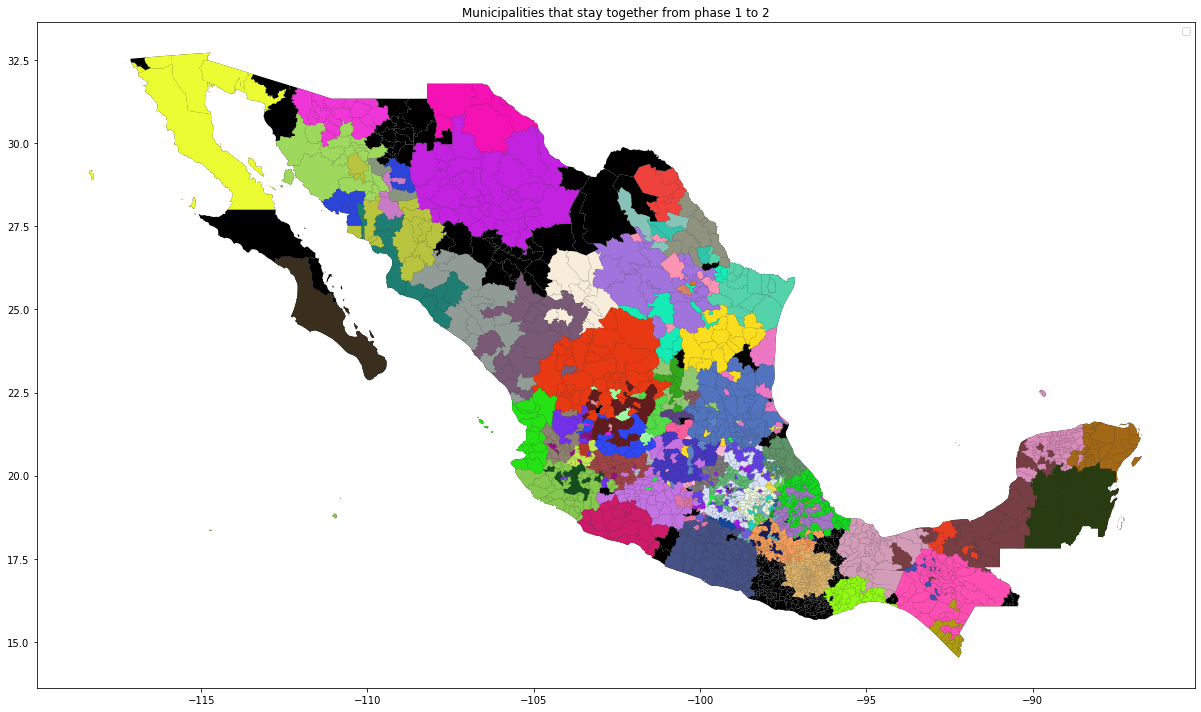

In [62]:
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return ("#"+color)


def graph_overlap(overlap_set):

    fig, ax = plt.subplots(figsize=(20,10))

    (urban_shapes).plot(ax=ax, color='black');
    
    for i in (overlap_set):
                                
        (urban_shapes.loc[list(i),:]).plot(ax=ax, color=randomcolor())

    plt.legend()

    plt.title('Municipalities that stay together from phase 1 to 2')

    plt.tight_layout()
    
graph_overlap(mun_same_reg)


In [ ]:
mun_same_reg[0].pop()